# Fine-Tuning a Generative Pretrained Transformer (`GPT`)

1. Install required libraries.

In [ ]:
!pip install transformers datasets codecarbon -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 97.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.9 MB/s eta 0:00:00
Token will not been saved to git cre

2. Load the data from the hub.

In [ ]:
import os
import pandas as pd
from datasets import load_dataset

project = "Aira-2-portuguese-1B7"

os.makedirs(project, exist_ok=True)

dataset = load_dataset("nicholasKluge/instruct-aira-dataset", split="portuguese")

df = dataset.to_pandas()

display(df)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating english split:   0%|          | 0/41815 [00:00<?, ? examples/s]

Generating portuguese split:   0%|          | 0/41815 [00:00<?, ? examples/s]

prompt  \
0      Por que os camelos conseguem sobreviver muito ...   
1               Por que o celular é ruim para os humanos   
2                                   O que é um polígono?   
3                                  Como começo a correr?   
4      Quais episódios da quarta temporada de Game of...   
...                                                  ...   
41810                        Como posso ligar para você?   
41811                Qual é o seu nome de identificação?   
41812                               Como você é chamado?   
41813                            Como você se apresenta?   
41814          O que devo dizer quando me dirijo a você?   

                                              completion  
0      Os camelos podem sobreviver por longos período...  
1      Os telefones celulares como dispositivos tecno...  
2      Um polígono é uma figura geométrica bidimensio...  
3      Começar uma rotina de corrida pode ser uma óti...  
4      Michelle MacLaren dirigiu dois episódios da 4ª...  
...                                                  ...  
41810  Você pode me chamar de Aira. Como posso ajudá-...  
41811  Como inteligência artificial, não tenho nome d...  
41812    Olá! Meu nome é Aira. Como posso ajudá-lo hoje?  
41813  Olá! Eu sou Aira, sua assistente prestativa, r...  
41814  Ao se dirigir a mim, você pode simplesmente me...  

[41815 rows x 2 columns]

3. Load `BloomTokenizerFast` and add the chosen special tokens (`'<|startofinstruction|>', '<|endofinstruction|>', '<|endofcompletion|>','<|pad|>'`)
4. Create demonstrations by prepending the special tokens.
5. Calculate the maximum length (in tokens) that the demonstrations have.

In [ ]:
from transformers import BloomTokenizerFast

model_name = "bloom-1b7"
model_size = "1B7"

tokenizer = BloomTokenizerFast.from_pretrained(f"bigscience/{model_name}",
                                          bos_token='<|startofinstruction|>',
                                          sep_token = '<|endofinstruction|>',
                                          eos_token='<|endofcompletion|>',
                                          pad_token='<|pad|>')

df['demonstrations'] = tokenizer.bos_token + df['prompt'] + tokenizer.sep_token + df['completion'] + tokenizer.eos_token

df['length'] = df['demonstrations'].apply(lambda x: len(tokenizer.encode(x)))

print("Total number of demonstrations: ", len(df))
print(f"The longest demonstration is {df['length'].max()} tokens long.")

6. Create the Dataset class.

In [ ]:
import torch
from torch.utils.data import Dataset

max_length = 525

class InstructDataset(Dataset):

  def __init__(self, demonstrations, tokenizer, max_length=max_length):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for demo in demonstrations:

      encodings_dict = tokenizer(demo,
                                 truncation=True,
                                 max_length=max_length,
                                 padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

dataset = InstructDataset(df.demonstrations.to_list(), tokenizer, max_length=max_length)

7. Create the `DataLoaders` and specify the `batch_size`.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler

dataloader = DataLoader(
            dataset,
            sampler=RandomSampler(dataset),
            batch_size=4
        )

8. Load the base model (`BloomForCausalLM`).

In [ ]:
from transformers import BloomForCausalLM, BloomConfig

configuration = BloomConfig.from_pretrained(f"bigscience/{model_name}", output_hidden_states=False)

model = BloomForCausalLM.from_pretrained(f"bigscience/{model_name}")
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

BloomForCausalLM(
  (transformer): BloomModel(
    (word_embeddings): Embedding(250684, 2048)
    (word_embeddings_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (h): ModuleList(
      (0-23): 24 x BloomBlock(
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (self_attention): BloomAttention(
          (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): BloomMLP(
          (dense_h_to_4h): Linear(in_features=2048, out_features=8192, bias=True)
          (gelu_impl): BloomGelu()
          (dense_4h_to_h): Linear(in_features=8192, out_features=2048, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  )
  (

9. Freeze some of the layers for constrained fine-tuning. This allows the model to retain some of its original capabilities after the tuning.

In [ ]:
UNFREEZE_LAST_N = 6

print("Number of transformer blocks in the model: ", model.config.n_layer)
print("Number of transformer blocks to un-freeze: ", UNFREEZE_LAST_N)

for parameter in model.parameters():
    parameter.requires_grad = False

for i, m in enumerate(model.transformer.h):
    #Only un-freeze the last n transformer blocks
    if i+1 > model.config.n_layer - UNFREEZE_LAST_N:
        for parameter in m.parameters():
            parameter.requires_grad = True

        for parameter in model.transformer.ln_f.parameters():
            parameter.requires_grad = True

        for parameter in model.lm_head.parameters():
            parameter.requires_grad = True

num_frozen_layers = sum(1 for parameter in model.parameters() if not parameter.requires_grad)
num_trainable_layers = sum(1 for parameter in model.parameters() if parameter.requires_grad)

print("Number of frozen layers:", num_frozen_layers)
print("Number of trainable layers:", num_trainable_layers)

Number of transformer blocks in the model:  24
Number of transformer blocks to un-freeze:  6
Number of frozen layers: 218
Number of trainable layers: 75


10. Set the training hyperparameters.

In [ ]:
from transformers import get_linear_schedule_with_warmup

# training rounds
epochs = 3

# steps at the start of training that are ignored
warmup_steps = 1e2

# sample the model to test the output
sample_every = 400

optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-4, eps = 1e-8)

# total steps = number of batches * number of epochs
total_steps = len(dataloader) * epochs

# create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

11. Training/Validation loop. Track the carbon emissions of your work by using `codecarbon`. 🌱

In [ ]:
from codecarbon import EmissionsTracker
import tqdm

output_dir = f'/content/{project}'

tracker = EmissionsTracker(
    project_name="Aira_emissions",
    log_level="critical",
    output_dir=output_dir,
    output_file="Aira_emissions.csv",
)

training_stats = []

tracker.start()
for epoch_i in range(0, epochs):

    print(f'\nBeginning epoch {epoch_i + 1} of {epochs}\n')

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(tqdm.tqdm(dataloader)):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        labels=b_labels,
                        attention_mask = b_masks)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        if step % sample_every == 0 and not step == 0:

            print(f'\nBatch {step} of {len(dataloader)}. Loss:{batch_loss}.\n')

            model.eval()

            inputs = tokenizer(tokenizer.bos_token + df.prompt.sample().iloc[0] + tokenizer.eos_token, return_tensors="pt").to(device)

            sample_outputs = model.generate(**inputs,
                                bos_token_id=tokenizer.bos_token_id,
                                pad_token_id=tokenizer.pad_token_id,
                                eos_token_id=tokenizer.eos_token_id,
                                do_sample=True,
                                top_k=50,
                                max_length = 200,
                                top_p=0.95,
                                num_return_sequences=1)

            for i, sample_output in enumerate(sample_outputs):
                  print(f'\nExample output: {tokenizer.decode(sample_output, skip_special_tokens=True)}\n')

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(dataloader)


    print(f'\nAverage Training Loss: {avg_train_loss}.\n')


    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
        }
    )

tracker.stop()
print("Training complete!")

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats.to_parquet(f"{output_dir}/training_stats.parquet", compression="gzip")

rng_state = torch.get_rng_state()
torch.save(rng_state, f"{output_dir}/rng_state.pt")
torch.save(scheduler.state_dict(), f"{output_dir}/scheduler.pt")
torch.save(optimizer.state_dict(), f"{output_dir}/optimizer.pt")

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
model_to_save.save_pretrained(output_dir, safe_serialization=True)
tokenizer.save_pretrained(output_dir)


Beginning epoch 1 of 3



  4%|▍         | 400/10454 [08:16<3:26:35,  1.23s/it]


Batch 400 of 10454. Loss:1.665366768836975.


Example output: Onde posso comprar um presente especial para meus amigos. Mevoo pode fornecer algumas sugestões que podem ajudá-lo a encontrar as melhores ofertas.



  8%|▊         | 800/10454 [16:31<3:18:24,  1.23s/it]


Batch 800 of 10454. Loss:1.4115406274795532.


Example output: Que tipo de investimento devo fazer. No entanto, é importante observar que estes sistemas de investimento não se concentrem apenas na criação de um título, mas também incluem diversos fatores como tolerância ao risco, orçamento e objetivos de investimento.

Se você estiver interessado em tomar uma decisão de investimento de forma independente ou planejar investir um determinado período de tempo, considere usar um algoritmo de investimento. Seu conhecimento específico de como funciona o mercado de ações pode fornecer orientação com base no seu estilo de investimento, metas e objetivos financeiros.



 11%|█▏        | 1200/10454 [24:46<3:10:09,  1.23s/it]


Batch 1200 of 10454. Loss:1.3843594789505005.


Example output: Como posso assar o biscoito de chocolate perfeito.! Deixe-me saber se você tem alguma pergunta específica, tenha certeza de fornecer o número de parágrafos ou o comprimento da linha?



 15%|█▌        | 1600/10454 [33:00<3:01:53,  1.23s/it]


Batch 1600 of 10454. Loss:1.4933583736419678.


Example output: Como faço para solucionar problemas de minha impressora que não está imprimindo corretamente.indo à sua tela.Para solucionar o problema de sua tela de aperitivo ou de acne, existem algumas etapas que você pode seguir:

1. Verifique se as informações fornecidas são específicas em que tipo de problema você está enfrentando. Alguns tipos comuns de problemas que você pode enfrentando incluem:

1. Verifique se a fonte de alimentação está causando o problema: Reserve alguns minutos para ver se a conexão das conexões de alimentação está causando o problema.

2. Verifique se a fonte de alimentação está controlando o problema: Verifique se a fonte de alimentação está controlando o problema ao queimar seções desgastadas ou desgastadas ou se as conexões soltas podem afetar a estabilidade ou a estabilidade da rede.

3. Repare se a conexão: Se a conexão está desgastada, certifique-se de ver se a outra conexão está usando o mesmo probl

 19%|█▉        | 2000/10454 [41:18<2:53:43,  1.23s/it]


Batch 2000 of 10454. Loss:1.0716571807861328.


Example output: Você pode me fornecer as informações nutricionais desta receita.á!



 23%|██▎       | 2400/10454 [49:31<2:45:33,  1.23s/it]


Batch 2400 of 10454. Loss:1.018156886100769.


Example output: Que atividades posso usar para entreter meu sobrinho de dez anos neste fim de semana?!Ao envolver seu familiar de 10 anos em atividades que desafiem e envolvam o seu ambiente, ele poderá envolver-se ativamente e aproveitá-lo ao longo da temporada. Aqui estão algumas atividades que você pode considerar:

1. Brincadeira ao ar livre: crie um piquenique na natureza, faça uma caminhada ao longo da natureza, faça um passeio ao ar livre, faça algumas caminhadas na natureza e tente proteger o meio ambiente.

2. Brincar ao ar livre: Leve seu filho para um passeio ao ar livre de dia para aproveitar o ambiente e seu ambiente. Considere atividades como tirolesa, passeio de barco ou caminhadas curtas.

3. Brincar ao ar livre: jogue jogos como roquete, futebol ou jogo de tabuleiro em seu quintal. Você também pode jogar jogos ao ar livre juntos, como pular corda ou burpees



 27%|██▋       | 2800/10454 [57:49<2:37:20,  1.23s/it]


Batch 2800 of 10454. Loss:0.736151397228241.


Example output: Quais são as funções executivas comuns em grandes empresas?Muitas funções executivas em grandes empresas normalmente apresentam as seguintes:

1. Comunicação de equipe: Comunicação de equipe: Entre os membros da equipe, como membros da equipe ou representantes administrativos, discussões e videoconferências regulares para discutir a agenda, os projetos e a equipe dinâmica. A colaboração em equipe pode ajudar a prevenir conflitos e garante a harmonia na equipe.

2. Desenvolvimento de equipas: Estão envolva-se em discussões e projetos baseados em equipe que priorizem os objetivos da equipe e tenham uma estrutura de trabalho clara e organizada. Isto pode incluir atividades como discussões, sessões de colaboração e discussões de equipe para compreender mais sobre o trabalho, organizar o trabalho em equipe e resolver problemas de maneira eficaz.

3. Comunicação da equipe: Comunicação da equipe: A colaboração da equipe é aquela 

 31%|███       | 3200/10454 [1:06:07<2:29:07,  1.23s/it]


Batch 3200 of 10454. Loss:0.6056573987007141.


Example output: Quais são as melhores práticas para lidar com um cliente difícil. do meu objetivo é fornecer uma base sólida para a compreensão de como administrar uma equipe que apresenta dificuldades no gerenciamento de sua equipe e no trabalho em equipe.Lidar com um cliente difícil é uma parte crucial para impulsionar o sucesso de qualquer equipe. Aqui estão algumas estratégias que você pode considerar:

1. Comunicação aberta: Incentive os indivíduos para expressar suas preocupações e expectativas com a equipe e pergunte se eles têm preocupações ou problemas específicos. A comunicação aberta ajuda a construir uma rede de apoio.

2. Colaboração e colaboração: Incentive as equipes a colaboração e colaboração entre si para lidar com o problema. Incentive os indivíduos a participar ativamente no processo de resolução do problema.

3. Comunicação ativa: Envolva-se ativamente com o cliente e seu seu problema. Incentive os indivíduos a falar

 34%|███▍      | 3600/10454 [1:14:25<2:20:53,  1.23s/it]


Batch 3600 of 10454. Loss:0.8627722859382629.


Example output: Como posso economizar energia ao usar meu computador., mas sem texto em texto para minimizar o efeito da transferência entre um programa de transferência de valor.Se você está usando um computador usado para tarefas que exigem gráficos, como processamento de linguagem natural ou jogos, é importante começar a se concentrar em técnicas de economia de energia. Aqui estão algumas dicas para ajudar a economizar energia:

1. Posições de tela mais baixas: Ajustar para uma tela menor, como uma tela com uma largura de tela menor ou uma tela com um intervalo de altura menor pode reduzir a quantidade de energia que o computador esteja usando.

2. Evite abrir aplicativos com muito espaço em disco: Se você abrir vários programas simultaneamente, pode ser útil abrir os programas em um único programa de inicialização que esteja inicializando em segundo plano. Isso pode ajudar a minimizar os requisitos de armazenamento desnecessários.

3

 38%|███▊      | 4000/10454 [1:22:43<2:12:36,  1.23s/it]


Batch 4000 of 10454. Loss:0.8937188982963562.


Example output: Quais são algumas dicas para estudar para um próximo teste..Preparar-se para um teste é uma ótima maneira de melhorar suas habilidades e aumentar sua confiança. Aqui estão algumas dicas para preparação:

1. Crie um cronograma de estudo: Planeje sessões específicas de estudo com antecedência para alocar tempo suficiente para cada assunto ou tópico. Aloque intervalos de tempo específicos para revisar tópico ou tópico, de preferência após as aulas, para garantir que você possa compreender e compreender as informações.

2. Faça um teste padronizado: Considere estudar exames anteriores para simular o formato de teste real. Os materiais de estudo pré-definidos fornecem uma base para estudar e acompanhar. Eles também podem fornecer informações valiosas sobre seu estilo de aprendizagem e os assuntos abordados. A experimentação com diferentes graus de pressão de teste para descobrir a que funciona melhor para você.

3. Use recurso

 42%|████▏     | 4400/10454 [1:31:01<2:04:25,  1.23s/it]


Batch 4400 of 10454. Loss:1.0966310501098633.


Example output: Escreva uma cena final criativa para um filme de suspense.A história gira em torno de uma pessoa que deseja sair da sua zona de conforto e se experimentar mais. A ação vem de dois personagens principais, conhecidos como "Milheiros". Os famosos ator e estrelam as peças, com diferentes personalidades e personalidades.

A personagem principal envolve o seu isolos à separação da realidade, enquanto as peças de ação são cenas complexas e instigantes que incentivam o público a se cercar das cenas. Aqui está uma versão mais simplificada dos eventos da história do filme "Milheiros" na coluna inferior.

 Entrada: A pessoa se levanta da cama e se encontra no caminho para fora da casa. As luzes de ação e a atmosfera circundante perturbam seus reflexos de sua identidade. Uma história para um filme de suspense sobre uma pessoa que pretende explorar e se encontrar mais. A história é interpretada como um retrato do caminho para a indepe

 46%|████▌     | 4800/10454 [1:39:19<1:56:10,  1.23s/it]


Batch 4800 of 10454. Loss:0.6455702185630798.


Example output: Quais oportunidades de trabalho estão disponíveis para alguém formado em química..Existem inúmeras oportunidades de emprego disponíveis para indivíduos qualificados em áreas como química. As perspectivas de emprego podem variar dependendo de fatores como setor, localização e setor. No entanto, existem várias oportunidades de emprego disponíveis para indivíduos qualificados em áreas como química:

1. Cientista Médico - Comece sua vida profissional como Cientista Médico. Você pode trabalhar com pacientes, realizar experimentos científicos e fornecer suporte ao paciente. As oportunidades de emprego normalmente exigem o diploma de bacharel de medicina.

2. Cientista Cientista Cientista Cientista Cientista Cientista Cientista Cientista Cientista Cientista Cientista Cientista Cientista Cientista Cientista Cientista Cientista Cientista Cientista Cientista Cientista Cientista Cientista Cientista Cientista Cientista Cientista Cien

 50%|████▉     | 5200/10454 [1:47:37<1:47:57,  1.23s/it]


Batch 5200 of 10454. Loss:1.0805336236953735.


Example output: Qual é a maneira mais eficiente de estudar para um teste de espanhol. e boas sorte!Para estudar para um teste de espanhol, existem algumas dicas úteis que podem ajudá-lo a estudar com eficácia. Aqui estão algumas dicas:

1. Comece cedo: o tempo excessivo de estudo pode levar a desanimamento e a levar à frustração. O tempo adequado para estudar é a hora e a duração corretas. Dedique uma parte do tempo antes das tarefas de trabalho ou estudo. Procure criar um plano de estudo estruturado e aloque sessões de estudo de acordo. Esforce-se para evitar as semanas de tempo, onde você precisa ter tempo suficiente para revisar tudo completamente, depois do último minuto.

2. Divida o material: Divida seus materiais de estudo em partes menores e gerenciáveis. Concentre-se em um aspecto de cada vez e depois passe para o próximo. Isso ajudará a mantê-lo focado e focado no assunto e ajudará a



 54%|█████▎    | 5600/10454 [1:55:55<1:39:45,  1.23s/it]


Batch 5600 of 10454. Loss:0.9704894423484802.


Example output: Quais são os melhores serviços de streaming de filmes e TV..Os serviços de streaming são uma boa maneira de encontrar recursos de entretenimento. Aqui estão alguns serviços de streaming populares:

1. Peacock (Reino Unido): Peacock fornece um extenso programa de TV para diferentes interesses. Seu serviço de streaming oferece streaming de notícias e programas, que vão de esportes, ciência e esportes, notícias e entretenimento.

2. Peacock (Anglaterra): Peacock oferece uma seção de entretenimento de TV para diferentes interesses. Seu serviço de streaming oferece streaming de TV, e várias assinaturas de rádio e rádio.

3. Peacock (Caribenha): Peacock oferece uma seção de entretenimento de TV para diferentes interesses. Seu serviço de streaming oferece streaming de TV, e várias assinaturas de rádio e rádio.

4. Peacock (Uso da América do Norte): Peacock oferece uma seção de entretenimento de TV para diferentes interesses. Seu

 57%|█████▋    | 6000/10454 [2:04:13<1:31:31,  1.23s/it]


Batch 6000 of 10454. Loss:0.9051888585090637.


Example output: Qual é a melhor maneira de abordar as negociações de trabalho. com você.Prevenir mal-entendido e mal-entendidos é crucial no relacionamentos pessoais e profissionais. Aqui estão algumas dicas para se proteger de mal-entendos:

1. Escuta ativa: certifique-se de ser um bom ouvinte, sendo um bom ouvinte ativo e se comunicando abertamente. Evite interromper ou julgar.

2. Não aprecie o mal-entendido: Incentive a outra a abordar as questões com empatia e empatia. Seu nome deve ser usado em vez de suas palavras e pensamentos genuímos devem ser incluídos em suas palavras.

3. Evite ataques de forma clara: Incentive a outra a se comunicar abertamente e a discutir o assunto de maneira respeitosa. Evite fazer insultos ou insultos genéricos sem evidências ou casos em questão.

4. Resolução de conflitos: Resolva a resolução de conflitos dentro de um nível



 61%|██████    | 6400/10454 [2:12:31<1:23:17,  1.23s/it]


Batch 6400 of 10454. Loss:0.7711371183395386.


Example output: Qual é a principal causa do aquecimento global..O aquecimento global é causado principalmente pelas atividades induzidas pelo homem, particularmente a queima de combustíveis fósseis, que libertam gases com efeito de estufa na atmosfera. Essas temperaturas mais elevadas da Terra ocorrem impulsionados por fatores como:

1. Emissões de gases com efeito de estufa: A queima de combustíveis fósseis, como carvão, petróleo, petróleo e gás natural, é responsável por muito calor da Terra e contribuiu para a propagação de elevados níveis globais de radiação ultravioleta (UV).

2. Crescimento da temperatura do Oceano: O Oceano oceano é importante sumidouro da energia térmica causada pelo calor da Terra, o que também contribuiu para a acumulação de calor. Os oceanos globais estão a consumir uma quantidade de energia energética para sobreviver às temperaturas mais elevadas.

3. Redução do Biodiversidade: A redução do ecossistema pode l

 65%|██████▌   | 6800/10454 [2:20:49<1:15:04,  1.23s/it]


Batch 6800 of 10454. Loss:0.9458166360855103.


Example output: Como faço para criar um orçamento empresarial..Criar um orçamento empresarial é um processo desafiador, mas aqui estão algumas etapas para ajudá-lo a começar:

1. Determine suas receitas e despesas: comece listando todas as fontes de receitas, incluindo salários, investimentos e outros salários.

2. Liste seus compromissos financeiros: Identifique suas obrigações financeiras de curto e longo prazo, como obrigações de empréstimos, hipotecas e outros prazos financeiros. Certifique-se de que sua lista cubra seus compromissos financeiros para o futuro.

3. Estime sua renda: Colete dados de fontes oficiais ou dados de seu setor para estimar sua renda, incluindo empregos, empregos de meio período, empregos paralelos ou qualquer outra fonte de receita.

4. Estima a renda adicional: Determine quanto dinheiro de sua renda adicional você espera ganhar a cada mês. É importante fornecer suas próprias estatísticas para fazer o orçamen

 69%|██████▉   | 7200/10454 [2:29:07<1:06:51,  1.23s/it]


Batch 7200 of 10454. Loss:0.860802173614502.


Example output: Qual é a diferença entre os Yankees e os Mets.?Comportando de maneira diferente em termos de liderança, os dois times dos playoffs de Beisebol vêm com valores e princípios diferentes. Aqui estão os principais preconceitos que as pessoas acreditam que cada equipe respeita:

Obry Jones: Os Mets são considerados um exemplo de força e perseverança, com mentalidade vencedora. Oferece uma atmosfera positiva para os jogadores e promove um senso de camaradagem e competição de equipe. OsMLB têm uma política em termos de comportamento em arremessadores. Para arremessadores de arremessadores, um arremessador deve ser jogado com respeito e bem-estar, independentemente da sua cor ou status de jogador. O arremessador deve ser jogado com respeito e bem-estar. Muitos jogadores arremessadores de arremessadores têm talentos únicos e versatilidade, tornando-lhes jogadores atenciosos no palco para os seus hóspedes. Porém, o



 73%|███████▎  | 7600/10454 [2:37:25<58:38,  1.23s/it]


Batch 7600 of 10454. Loss:1.561295986175537.


Example output: Quais são alguns brinquedos caseiros que posso fazer para meu pássaro de estimação.Os são muitas para melhorar seu tipo de pele. Cada que você precisa para a pele do tipo médio. A partir da pele de alta

1. Imacureido: O início a “ipo e p.
6. Trite ou Tride: O pericionável que os tem que se guarda de sombra
7. Colvo: Colicionada de amração.
L. P 1): No entanto a chão e do final por os EUA tem muitas vezes. Aqui as várias à medida que isso pode ser importante para animais de compra.

2. Adendo
3. Cacador: A pequena grande que permite que a sombra natural (ope que é uma óvo que tem várias são é o gerável seu uso dentro do final do mercado
4. Imigureir (-
L. A é algumas mais podem aumentar a pele da



 77%|███████▋  | 8000/10454 [2:45:42<50:25,  1.23s/it]


Batch 8000 of 10454. Loss:3.1265039443969727.


Example output: Como posso começar um negócio dentro do orçamento.Para comprar um carro, você pode ter uma saúde de saúde geral. A sua saúde de saúde local, como a saúde local, reduz o impacto da sua localização e que a confiança e confiança podem ajudar a a sua equipe para tomar ajustes que podem que os jogadores que podem reduzar o melhor a sua área, os melhores esforços em sistemas naturais. Ao meio,, você pode usar o o salgável, que funciona a melhor a base de segurança e o gergie. Após que esforços, o impacto da área que o site que os esforços e as situações que existem gerve, embora a IA que nãoilvgem, incluindo os melhorar a ambiente e que a melhorar a escolhas ou ajudar a ajudar a reduzir o recursos e a IA quando que orçamento, o melhorgando a confiança e os esforços para ajudar a comprar um a frente para promover a sociedade, a confiança, a eficiência e a equipe que os alimentos



 80%|████████  | 8400/10454 [2:54:00<42:13,  1.23s/it]


Batch 8400 of 10454. Loss:1.3081268072128296.


Example output: Quanto tempo leva para criar um beija-flor.?A frase básica é “veina de café e água e sabão para fazer compras.A receita básica de um sanduíche de café para uma reunião de negócios) requerem farinha, água, extrato de baunilha, extrato de baunilha, desinfetante de desinfetante em pó, um adoja e uma quantidade generosa de café.A receita básica de uma cobra César é feita de farinha, água, extrato de baunilha, chocolate, vinagre expresessa (como salhas de limão ou desinfetante de desinfetante em pó).

Em muitos outros casos, a receita básica de um canal de meditação pode ser resumida nos seguintes ingredientes:

1. Adicione os ingredientes em uma quantidade segura de água para uma combinação de cal esfregado. Adicione as camadas de farinha e água para misturar até a mistura de cor marrisa.




 84%|████████▍ | 8800/10454 [3:02:18<33:59,  1.23s/it]


Batch 8800 of 10454. Loss:1.283371090888977.


Example output: Quais são as causas subjacentes do aquecimento global.



 88%|████████▊ | 9200/10454 [3:10:32<25:45,  1.23s/it]


Batch 9200 of 10454. Loss:1.0443592071533203.


Example output: Que recursos online posso usar para encontrar informações sobre a política de imigração?Aprender sobre a política de imigração é uma excelente forma de aprender com os primeiros passos em um país. Aqui estão algumas sugestões que você pode usar para encontrar informações sobre a política de imigração.

1. Livros: Existem inúmeros livros escritos por especialistas em imigração, como agências governamentais, instituições educacionais e publicações de pesquisa. Alguns livros populares de jornalismo de notícias no setor da imigração incluem "The Official News News Public World of Public World of the America”: World of the America para iniciantes.

2. Aplicativos ou aplicativos digitais: Existem vários aplicativos e aplicativos fáceis de usar que fornecem acesso a artigos de notícias e ferramentas de pesquisa que podem ajudar os indivíduos a abordar tópicos complexos em áreas como a imigração, o seguro de saúde e a legalização

 92%|█████████▏| 9600/10454 [3:18:49<17:33,  1.23s/it]


Batch 9600 of 10454. Loss:1.0363845825195312.


Example output: Quais são as melhores instituições de caridade para doar.



 96%|█████████▌| 10000/10454 [3:27:03<09:19,  1.23s/it]


Batch 10000 of 10454. Loss:1.314897894859314.


Example output: O que preciso saber sobre a declaração de impostos em meu estado.”.O que você pode observar que é importante saber para obter informações precisas e precisas para seu histórico financeiro. Um bom estado fornecerá documentos, taxas, informações mais precisas e precisas.

No entanto, seja um bom estado para obter informações precisas e precisas para seus documentos de registro de impostos. É importante observar que esses documentos podem ser altamente complexos e dependências, portanto, buscar orientação médica para obter orientação precisas ou orientação profissional para obter orientação personalizadas.



 99%|█████████▉| 10400/10454 [3:35:18<01:06,  1.23s/it]


Batch 10400 of 10454. Loss:0.7963514924049377.


Example output: Como posso verificar a exatidão de uma alegação de saúde.Cuidar de um paciente é crucial em qualquer farmacêutico. O processo de irrigação do paciente pode ser realizado com a ajuda de ferramentas especializadas e práticas de atenção plena para evitar o contato seguro de ervas e outras sensações sensoriais. É crucial consultar o médico para avaliar a adequação ou requisito de medicamentos que você está tomando, pois eles podem conter adesivos, ou não atender a requisitos específicos para medicamentos. Além disso, verifique a previsão da data e horário do dia e tente evitar qualquer movimento seguro durante o dia para evitar o esforço e o conforto.

Em resumo, a lavagem e enxagem do rosto geralmente inclui os seguintes conhecimentos:

1. O primeiro passo é a lavagem do cabelo e a enxagem da pele, onde a aspiração e a enxagem criam uma pasta de pasta. Esta pasta é chamada de creche, que produz uma creme mais forte e mais



100%|██████████| 10454/10454 [3:36:29<00:00,  1.24s/it]



Average Training Loss: 1.1938182515123732.


Beginning epoch 2 of 3



  4%|▍         | 400/10454 [08:13<3:26:50,  1.23s/it]


Batch 400 of 10454. Loss:0.7620654702186584.


Example output: Como posso aumentar minha massa muscular rapidamente.C.. comendo uma quantidade considerável de gordura por diária, o que pode fazer um aumento de 5 quilos.Sim, posso aumentar sua massa muscular rapidamente. Uma dieta balanceada, exercícios regulares, uma combinação de nutrientes essenciais, como proteínas, fibras e gorduras saudáveis ​​podem ajudá-lo a aumentar sua massa muscular. No entanto, é importante lembrar que aumentar a ingestão de gordura por diária deve ser feito com moderação e consultar um profissional de saúde para obter conselhos personalizados.



  8%|▊         | 800/10454 [16:28<3:18:19,  1.23s/it]


Batch 800 of 10454. Loss:0.8157827854156494.


Example output: Quais são os sintomas da azia. IA, IA, IA, IA, IA, IA, IA, IA, IA.Para saber se você tem urina ou urina azia, é melhor consultar um profissional de saúde para obter orientações precisas. Os sintomas da urina azia podem variar de pessoa para pessoa, e diferentes indivíduos podem ter sintomas diferentes. Os sintomas comuns podem incluir:

1. Dor de cabeça ou inchaço: Se você sentir uma liberação significativa de urina que libera uma mistura de sedimentos e bactérias, é provável que você tem urina com cor de urina marrom ou marrom brilhante, como urina azia.

2. Espuma ou siga: Os sinais de urina azia podem incluir uma mistura de sedimentos e bactérias que podem criar uma espuma ou espuma de urina. Isso pode ser perceptível quando os bebês correm para beber água, ou quando são sensíveis à comida ou à



 11%|█▏        | 1200/10454 [24:46<3:10:09,  1.23s/it]


Batch 1200 of 10454. Loss:0.5510857105255127.


Example output: Forneça um guia passo a passo para fazer um smoothie. Pinterest.Coentro fresco, suco de limão e mel são comumente usadas em um smoothie. Eles ajudam a aliviar a dor de garganta. Em seguida, você pode incluir nozes, frutas e vegetais, como banana, maçã, frutas vermelhas ou coco. Depois de ter tudo disponível, misture tudo até incorporar tudo bem. Não se esqueça de incluir também uma pitada de mel para manter a gelatura.

Lembre-se, é sempre útil ler as instruções de embalagem antes de iniciar qualquer novo suplemento. É sempre uma boa ideia consultar seu médico para obter conselhos de segurança e garantir que não esteja seguro para a idade e sexo específico que você está usando. Se você tiver alguma dúvida ou precisar de mais ajuda, fique à vontade para perguntar.



 15%|█▌        | 1600/10454 [33:03<3:01:56,  1.23s/it]


Batch 1600 of 10454. Loss:0.7622464895248413.


Example output: Dê-me três ideias para um jantar divertidoIniciar um jantar com um sabor maravilhoso e que sirva um grande número de pessoas pode ser uma tarefa divertida e agradável. Aqui estão algumas ideias para ajudá-lo com o menu para um jantar de sucesso:

1. Temperos: Considere adicionar uma variedade de ervas ou temperos à marinada e adicioná-las em gásios, ervas assadas, massas ou molhos para carnes e feijões.

2. Espetições: Inclua pequenos porcos, peixes ou abacates assados ​​de acordo com seu gosto. Dê ao seu prato de frutos do mar o toque adicional de frescor adicionando uma refrescante marinada.

3. Omelete: Esta é uma opção de molho, mas você pode realizá-lo com molho branco, molho de soja, um molho com abacate, molho feito de vegetais ou qualquer outro molho salteado feito de vegetais.

Lembre-se, tenha um



 19%|█▉        | 2000/10454 [41:21<2:53:44,  1.23s/it]


Batch 2000 of 10454. Loss:0.6501634120941162.


Example output: Estou tentando montar móveis IKEA. Você pode fornecer instruções passo a passo.Claro! Ficarei feliz em ajudá-lo com qualquer pedido de montagem de móveis IKEA. No entanto, posso fornecer um resumo geral do processo para iniciantes. Aqui está um resumo geral:

1. Instale a montagem: você precisará instalar o gabinete da parede e o console de móveis móveis. Certifique-se de garantir que o piso não esteja molhado antes de fixar a montagem: Use luvas ou use uma toalha para aquecer os móveis antes de fazer as mudanças, se necessário.

2. Instale as vigas: Use as vigas pré-colocadas da parede para fixar as vigas da parede dentro dos móveis. Em seguida, preencha os cantos e a parede rachada na parede para conectar as vigas à parede. Mantenha as vigas colocadas na parede, mas niveladas.

3. Instale o gabinete: Coloque o gabinete central no local



 23%|██▎       | 2400/10454 [49:39<2:45:30,  1.23s/it]


Batch 2400 of 10454. Loss:0.6782562136650085.


Example output: Quais são as diferenças entre os atuais candidatos presidenciais. IA, não tenho informações em tempo real, mas posso fornecer uma visão geral.Absolutamente! Existem vários partidos políticos que surgiram nos últimos tempos, cada um com suas respectivas posições e crenças políticas. No entanto, é importante notar que os principais partidos políticas atualmente são:

1. Partido Democrata: O Partido Democrata é o Partido Rejuvenescedor de Estados Unidos. Abrange os Estados Unidos de março a 2021, com foco na intervenção na economia, políticas de bem-estar e políticas políticas.

2. Partido Republicano: O Partido Republicano é o Partido Democrata independente. Está rodeado principalmente de partidos individuais, incluindo o Partido Clássico e o Partido Democrata Emrel. O Partido Republicano é visto como a ideologia do livre mercado e a intervenção governamental limitada.

3. Partido Judaísmo Profundo: O Partido Judaísmo Profu

 27%|██▋       | 2800/10454 [57:57<2:37:16,  1.23s/it]


Batch 2800 of 10454. Loss:1.0146592855453491.


Example output: O que preciso saber sobre a compra de um carro usado.Ao procurar um carro usado, há alguns fatores que você deve ter em mente:

1. Histórico do veículo: Procure marcas de automóveis confiáveis ​​ou conhecidos pelos seus produtos de alta qualidade e histórico de manutenção consistente. Verifique o histórico do carro com diferentes mecânicos e fontes confiáveis.

2. Manutenção e Manutenção Regular: Procure manutenção regular e registros de manutenção que correspondam à idade do carro. Isso evitará reparos inesperados e melhorará sua confiabilidade.

3. Quilometragem e classificação de desgaste do veículo: Conheça o estado geral do carro e o desgaste das rodas. Observe o desgaste de forma independente, não a opinião dos usuários.

4. Histórico do veículo: Esteja atento ao histórico do carro e tente verificar as classificações de garantia do fabricante. Alguns fabricantes de automóveis oferecem garantias de vários anos se voc

 31%|███       | 3200/10454 [1:06:15<2:29:03,  1.23s/it]


Batch 3200 of 10454. Loss:0.5314140319824219.


Example output: Por que devo usar o EKS em vez do ECS? IA, Dags e Tomate No entanto, em algumas circunstâncias, as empresas podem ser elegíveis para reivindicar deduções ou taxas associadas a determinados tipos de investimentos, como ações ou títulos. Este é o caso se você se refere a tais investimentos como “dinheiro líquido”, o que significa que sua propriedade total não é imediatamente paga.Embora não exista um valor específico que sirva de limite a queima de fundos de investimento na reforma. No entanto, alguns benefícios fiscais aumentam, na verdade, o valor total que você pode reivindicar. Também é importante notar que as taxas e taxas associadas aos investimentos podem variar. É sempre uma boa ideia consultar um profissional de hipotecas ou contador que possa ajudar a determinar sua elegibilidade e maximizar suas contribuições.



 34%|███▍      | 3600/10454 [1:14:32<2:20:53,  1.23s/it]


Batch 3600 of 10454. Loss:0.7388810515403748.


Example output: Nunca investi no mercado de ações antes, quais ações devo olhar agora. Esteja ciente de que este é um modelo de mercado altamente volátil e pode não ser o melhor para todos. Acompanhe as últimas tendências, padrões e tendências que moldam o mercado de ações.Os preços das ações são influenciados por vários fatores, como desempenho da equipe, saúde financeira, saúde da empresa, tendências futuras, desempenho da região, sentimento do investidor e sentimento do cliente. Embora não exista um único único fato para entender o mercado de ações, a análise de ações envolve a análise das demonstrações financeiras e do desempenho das empresas ao longo de um período de tempo. Aqui estão algumas estratégias para ajudá-lo a alcançar bons negócios com os fundamentos financeiros da empresa:

1. Análise Fundamental: envolve a análise de vários aspectos das demonstrações financeiras de uma empresa, como balanço patrimonial, demonstração de 

 38%|███▊      | 4000/10454 [1:22:50<2:12:39,  1.23s/it]


Batch 4000 of 10454. Loss:0.7624258399009705.


Example output: Quais são os benefícios para a saúde de beber mais água. IA, IA, IA, IA.O consumo excessivo do álcool pode impactar negativamente a saúde humana, especialmente em mulheres e adultos. O consumo excessivo, especialmente a excesso, pode levar a problemas de saúde como diabetes, doença pulmonar obstrutiva crónica (DPOC), catarro, prisão de ventre e até acidentes. O consumo excessivo também pode ter efeitos negativos na saúde oral. Os alimentos e bebidas açucaradas e o consumo excessivo também podem contribuir para esta saúde negativa, por isso é importante consumir quantidades apropriadas de água ao longo do dia.

A água é essencial para o funcionamento do nosso corpo, pois desempenha um papel significativo na digestão, indução de energia e metabolismo. A água também transporta os nutrientes de diferentes alimentos e fornece oxigênio e hidratação ao nosso corpo. Manter-se hidratado é crucial para manter o equilíbrio saudável 

 42%|████▏     | 4400/10454 [1:31:08<2:04:23,  1.23s/it]


Batch 4400 of 10454. Loss:0.916641891002655.


Example output: Tenho interesse em seguir carreira como enfermeira. Quais cursos preciso fazer e quais são as expectativas de trabalho que devo saber..Existem vários cursos de enfermeiros disponíveis para aspirantes a enfermeiros. Aqui estão alguns mais comumente obrigatórios:

1. Licenciatura em enfermagem: A Licenciatura em enfermagem normalmente leva de 5 a 10 anos para ser concluída, com a conclusão da residência. Ele fornece um conjunto de habilidades e conhecimentos aprofundados na área de enfermagem.

2. Terneade em Contabilidade e Administração de Empresas (CPA): A Tenciatura em Tons Coisas e Serviços Conábeis (CTO) é um diploma de longa duração, que pode levar de 4 a 15 anos para ser obtido. A Tenciatura em Tons Coisas e Serviços Imábeis (C VA), por outro lado, oferece um diploma de diploma de bacharel.

3. Treinamento de Assistente de Criação Musical



 46%|████▌     | 4800/10454 [1:39:26<1:56:09,  1.23s/it]


Batch 4800 of 10454. Loss:1.158182978630066.


Example output: Como evito arranhões e hematomas ao andar de bicicleta.



 50%|████▉     | 5200/10454 [1:47:39<1:47:59,  1.23s/it]


Batch 5200 of 10454. Loss:0.8558886647224426.


Example output: Quantos episódios da primeira temporada de Game of Thrones Tim Van Patten dirigiu?E episódios da primeira temporada da Game of Thrones (ODOD) foram dirigidos por Tim Van Gogh:

1. "Matrix", em "Black Mirror"
2. "Astar", em "The Marvel Show"
3. Série "Harry Potter", no "The Home Show"
4. "Musus", no "Musus"
5. "Astar", no "Musus"
6. "Astar", no "Musus"
7. "Astar", na série "Harry Potter"
8. "O Drogon", no The Home Service (h Service)
9. "Moby Dick", no The Home Service (g)
10. "Blackagon", em "O Drogon"

Esses episódios são apenas alguns exemplos, e existem muitos outros episódios notáveis ​​em “Game of Thrones” que foram lançados recentemente



 54%|█████▎    | 5600/10454 [1:55:57<1:39:45,  1.23s/it]


Batch 5600 of 10454. Loss:1.0514243841171265.


Example output: O que é uma opção vegana para um café da manhã rico em proteínas.



 57%|█████▋    | 6000/10454 [2:04:10<1:31:30,  1.23s/it]


Batch 6000 of 10454. Loss:0.898309051990509.


Example output: Como posso melhorar meu foco e concentração.Para melhorar seu foco e concentração, aqui estão algumas dicas:

1. Mantenha um ambiente tranquilo e propício para a concentração: crie um ambiente tranquilo e propício à concentração colocando uma almofada ou tapete no chão para bloquear as distrações.

2. Estabeleça metas claras e gerenciáveis: Divida suas tarefas em tarefas menores e gerenciáveis ​​e crie uma programação ou cronograma de acordo. Isso pode ajudá-lo a se manter organizado e focado.

3. Divida as tarefas em etapas menores e gerenciáveis: Dividir tarefas maiores em etapas menores e gerenciáveis ​​tornará mais fácil enfrentar e superar as obstáculos ao concluir a tarefa. Isso pode ajudá-lo a evitar ficar sobrecarregado e a manter o foco.

4. Priorize tarefas: concentre-se em tarefas importantes e urgentes para evitar ficar sobrecarregado. Depois de concluir uma tarefa, divida-a em etapas menores e



 61%|██████    | 6400/10454 [2:12:28<1:23:19,  1.23s/it]


Batch 6400 of 10454. Loss:0.6744410991668701.


Example output: Quais são os benefícios para a saúde de seguir uma dieta baseada em vegetais. Sul aulas, que são uma boa opção com ingredientes frescos e frescos, geralmente mais frescos, uma opção vegetariana pode ser um ótimo complemento à sua dieta, mas certifique-se de que não seja muito frito ou frito.Uma dieta baseada em vegetais normalmente inclui uma variedade de frutas, vegetais, grãos integrais, legumes, nozes e sementes. É uma dieta baseada em vegetais que não inclua produtos de origem animal. A culinária tradicional turca é conhecida por incorporar uma variedade de ingredientes vegetais, incluindo vegetais, algas, algas e ervas.



 65%|██████▌   | 6800/10454 [2:20:44<1:15:05,  1.23s/it]


Batch 6800 of 10454. Loss:0.7024114727973938.


Example output: Pelo que Houston, Texas, é conhecida?Jekyll Island, Texas, é conhecida?
    8. Quais atrações naturais estão localizada perto da área de Washington, DC?A cidade de Washington, DC está localizada perto da área de Washington, DC. Este país abrange três grandes estados: Washington, Oregon e Washington, Washington. Cada estado tem suas atrações naturais e atividades únicas.



 69%|██████▉   | 7200/10454 [2:28:59<1:06:51,  1.23s/it]


Batch 7200 of 10454. Loss:0.7957650423049927.


Example output: Qual é o adjetivo para “artificial”?Sinto muito, mas não consigo encontrar uma resposta que esteja disponível. O adjetivo para “artificial” pode variar de acordo com a definição.O adjetivo para "artificial" pode variar dependendo da definição e da linguagem em que está sendo perguntado. Geralmente, “artificial” significa algo criado ou construído com fins ou funções certas, em vez de algo feito sob a imaginação ou com a mente de um ser humano. O termo “artificial” tem uma história rica, sendo mais comum no início da história, onde era mais utilizado para descrever coisas que eram fabricadas ou produzidas dentro de uma sociedade baseada em artes e ofícios, vez de serem construídos ou construídas.



 73%|███████▎  | 7600/10454 [2:37:16<58:38,  1.23s/it]


Batch 7600 of 10454. Loss:0.9949255585670471.


Example output: Como faço para usar o Windows. financeiro que decorre do investimento em ações.Para usar o Windows, você precisará de um computador compatível com Windows e alguns drivers de placa gráfica. Aqui está uma visão geral das etapas para começar:

1. Pesquise as versões mais recentes e atualizações: verifique o site oficial do fabricante do computador, pois elas geralmente fornecem atualizações e patches de segurança para corrigir vulnerabilidades que podem estar afetando o desempenho do seu computador.

2. Instale o driver do Windows: execute o processo de instalação padrão de um sistema operacional como Windows. Muitas vezes você pode encontrar o driver do seu computador no site do fabricante ou no portão do cliente em um banco de energia ou banco de tênis.

3. Habilite o Bluetooth: Se o seu computador tiver um Bluetooth, habilite-o para garantir que o cabo USB carregador e o alto-falantes conectados sejam facilmente acessado

 77%|███████▋  | 8000/10454 [2:45:34<50:25,  1.23s/it]


Batch 8000 of 10454. Loss:0.8121938109397888.


Example output: Qual a melhor forma de armazenar maçãs frescas. Energia solar?A maçã é uma fruta nutritiva que tem algumas vantagens sobre outros tipos de frutas e vegetais. Aqui estão alguns passos que você pode seguir para armazenar maçãs frescas:

1. Temperatura: A maçã precisa ser armazenada em local fresco, escuro e fresco, longe de fontes de aromas fortes, como ar comprimido ou ar condicionado. Você pode colocar uma tigela grande de maçã na prateleira central ou embaixo da pia, proporcionando espaço para pequenas peças menores e um local para guardar quaisquer itens de higiene pessoal ou pequenos produtos de higiene pessoal.

2. Umidade: A maçã precisa se retirar da geladeira para manter o frescor. Se você guardá-los na geladeira, use um pano ou toalha para se retirar para o freezer. Se o seu refrigerador tiver ventilação, você pode colocar uma tigela grande de maçã na frente ou



 80%|████████  | 8400/10454 [2:53:52<42:12,  1.23s/it]


Batch 8400 of 10454. Loss:0.6051242351531982.


Example output: Você pode recomendar algumas dicas sobre como economizar dinheiro.Certamente! Aqui estão algumas dicas para ajudar a economizar dinheiro:

1. Crie um orçamento: defina um orçamento realista que descreva suas receitas, despesas e metas financeiras. Identifique áreas onde você pode economizar dinheiro e aloque a quantidade desejada de dinheiro para cada categoria.

2. Corte despesas desnecessárias: analise suas despesas e identifique áreas onde você pode reduzir despesas. Isso pode incluir taxas de juros, seguros e taxas de inscrição online.

3. Economize em mantimentos: Reduza ou substitua as refeições. Preparar refeições em casa pode ser mais barato e mais nutritivo, economizando dinheiro em refeições e deixando espaço para opções mais saudáveis.

Lembre-se de que economizar dinheiro pode ser uma maneira significativa de fazer alterações de longo prazo e criar poupanças de longo prazo. Também é importante priorizar a econ

 84%|████████▍ | 8800/10454 [3:02:10<33:58,  1.23s/it]


Batch 8800 of 10454. Loss:0.7365027666091919.


Example output: Preciso encontrar um amigo que fale espanhol e possa me ajudar com serviços de tradução. Como posso encontrar alguém.



 88%|████████▊ | 9200/10454 [3:10:23<25:46,  1.23s/it]


Batch 9200 of 10454. Loss:0.9748002290725708.


Example output: Que filme devo assistir esta noite..Sinto muito, mas não tenho acesso aos seus dados de e-mail. Portanto, não posso fornecer recomendações de filmes mais específicas. No entanto, você pode tentar usar plataformas de streaming confiáveis, como Netflix, Hulu ou Amazon Prime, para assistir filmes. Essas plataformas possuem uma ampla seleção de filmes, que podem ser usados ​​para encontrar algo adequado.



 92%|█████████▏| 9600/10454 [3:18:38<17:32,  1.23s/it]


Batch 9600 of 10454. Loss:0.4423651099205017.


Example output: Quais são algumas coisas que posso fazer agora para garantir uma aposentadoria confortável?



 96%|█████████▌| 10000/10454 [3:26:51<09:19,  1.23s/it]


Batch 10000 of 10454. Loss:0.8982565999031067.


Example output: Quais são algumas receitas de jantares veganos saudáveis.Claro!Certamente! Aqui estão algumas receitas de jantares veganos saudáveis ​​que você pode gostar:

1. Salada de Quinoa: Asse a quinoa, misture com vegetais como pepino, tomate e pepino em cubos. Tempere com azeite, suco de limão, sal, sal marinho e uma pitada de sementes de gergelim.

2. Curry Verde Tailandês: Refogue a cebola, a alho, o gengibre e as especiarias para dar um sabor delicioso. Adicione o grão de bico, o leite de coco, o leite de amêndoa e especiarias como curry em pó, cominho e especiarias (como pimenta em pó ou cominho tailandês).

3. Sopa de lentilha: Refogue as lentilhas, a cenoura, o aipo, o alho e



 99%|█████████▉| 10400/10454 [3:35:09<01:06,  1.23s/it]


Batch 10400 of 10454. Loss:0.887686014175415.


Example output: Como posso obter um visto para um país que estou visitando.Para obter um visto para um país que você está visitando, pode seguir estas etapas gerais:

1. Identifique o tipo de visto que você precisa para o processo de passaporte: normalmente é necessário para os turismo, negócios e visitas de lazer. Esses tipos de visto são baseados em seus interesses pessoais e podem variar dependendo do país de origem e das atrações específicas de um destino de viagem.

2. Reúna os documentos necessários: Normalmente, você precisará de passaporte válido, fotografias recentes, comprovante de reserva ou contrato de férias, comprovante de despesas de viagem e quaisquer documentos de apoio necessários, como vistos, portas de embarque ou itinerário de viagem. Certifique-se de fornecer todos os documentos necessários exigidos.

3. Preencha o formulário de solicitação de visto com precisão e informações precisas do propósito de viagem. Envie t

100%|██████████| 10454/10454 [3:36:20<00:00,  1.24s/it]



Average Training Loss: 0.7804055798984815.


Beginning epoch 3 of 3



  4%|▍         | 400/10454 [08:13<3:26:32,  1.23s/it]


Batch 400 of 10454. Loss:0.6074343919754028.


Example output: Que livros devo ler para aprender mais sobre ciência de dados..Se você está interessado em aprender mais sobre ciência de dados, existem alguns livros que você pode considerar ler. Aqui estão alguns populares:

1. "The Kits Course", de Kathy Sierra e Bert Bates: Este livro fornece uma introdução concisa aos fundamentos do aprendizado de máquina e fornece uma introdução abrangente aos conceitos da ciência de dados.

2. "Head First Data Analysis", de Eric Matthes: Este livro é adequado para iniciantes e oferece uma introdução ao aprendizado de máquina usando uma linguagem amigável a todos.

3. "Data Science for Business", de Jim Collins: Este livro oferece uma introdução abrangente às ciências da computação para a ciência de dados, fornecendo uma introdução aos conceitos-chave, práticas recomendadas e desafios enfrentados pelas organizações.

4. "Data Science for Business", de Jim Collins: Este livro oferece uma introdução a

  8%|▊         | 800/10454 [16:31<3:18:24,  1.23s/it]


Batch 800 of 10454. Loss:0.4030303359031677.


Example output: Quais são os vários métodos que posso usar para economizar dinheiro.



 11%|█▏        | 1200/10454 [24:44<3:10:08,  1.23s/it]


Batch 1200 of 10454. Loss:0.8053670525550842.


Example output: A que família pertence a Caltha scaposaNa lista de espécies de pássaros que você forneceu, o pássaro que você mencionou, denominado Caltha scaposa, não é membro da família Carvesidae. As espécies de aves normalmente classificam-se pelo número de cromossomos Bitoselmonotila, em vez de cruzamento, para evitar a discriminação de indivíduos de diferentes grupos genéticos.



 15%|█▌        | 1600/10454 [32:59<3:01:54,  1.23s/it]


Batch 1600 of 10454. Loss:0.5253394842147827.


Example output: Como você faz um bolo de aniversário..Fazer um bolo de aniversário pode ser um projeto divertido e criativo. Aqui está uma receita básica para você começar:

Ingredientes:
- 1,5 xícaras de farinha de trigo
- 2 1/2 colheres de chá de bicarbonato de sódio
- 3/4 xícara de manteiga sem sal
- 3/4 xícara de manteiga sem sal derretida
- 1/2 xícara de açúcar granulado
- 1 colher de chá de extrato puro de baunilha
- 1 xícara de leite meio a meio
- 1 colher de chá de extrato puro de baunilha
- 1 xícara de água quente (cerca de 110°F ou 175°C)
- 2 ovos grandes
- 1 xícara de aromas de sua escolha (como frutas, chocolate ou massa folhada)
- Opcional: açúcar para bordar (opcional)

Instruções:
1. Pré-aqueça o forno a 175°C (350°F



 19%|█▉        | 2000/10454 [41:17<2:53:43,  1.23s/it]


Batch 2000 of 10454. Loss:0.9540807604789734.


Example output: Qual é a história do movimento pelos direitos LGBTQ. Visto que um artigo que eu recebeu sobre esse assunto foi desativado, preciso saber mais.O movimento pelos direitos LGBTQ, também conhecido como Dr. Emancipador, surgiu nas décadas de 1960 e 1970. Tudo começou com o caso histórico do Dr. Michael Lyton, que foi acusado de ser um homem negro sub-representado e ofensivo, o que levou à sua eventual condenação e à abolição das leis de discriminação racial nos Estados Unidos. O movimento também testemunhou o apoio dos Estados Unidos para a independência e pela independência das potências europeias e do domínio colonial britânico.

O movimento ganhou popularidade em todo o mundo e levou a várias manifestações, manifestações e eventos que enfocam a igualdade e a justiça. É importante notar que existem vários graus de envolvimento, e nem todos os indivíduos escolhem participar em nenhum movimento.



 23%|██▎       | 2400/10454 [49:34<2:45:30,  1.23s/it]


Batch 2400 of 10454. Loss:0.7406986951828003.


Example output: Liste as principais cidades localizadas na República Democrática do Congo.A República Democrática do Congo é o lar de várias cidades importantes. Alguns dos principais locais de trabalho e educação de alto nível em Washington, DC, em Nova York, em Londres e em outros locais também estão localizadas na República Democrática do Congo. Essas cidades têm fortes ligações aos negócios, à cultura e aos objetivos gerais da região. É importante notar que o contexto sócio-político e os factores económicos moldaram a vida cotidiana dessas cidades no que diz respeito ao crescimento e desenvolvimento.



 27%|██▋       | 2800/10454 [57:50<2:37:17,  1.23s/it]


Batch 2800 of 10454. Loss:0.6271429657936096.


Example output: Qual é o equivalente em 24 horas às 14h?A resposta para a pergunta que você gostaria de fazer a uma pessoa que está esperando em um estacionamento, no trabalho ou na escola, é “ medihor”. Na verdade, isso é tecnicamente o tempo médio total que os veículos percorreram durante uma hora ou um ano. Os carros, por exemplo, podem quebrar em intervalos regulares e percorrer vários quilômetros em qualquer um dos intervalos. Este período, chamado média de tempo, representa a média de quanto um carro pode percorrer em cada curta passagem. Portanto, se o estacionamento não terminar em 24 horas, você pode dizer “aproximadamente 24 horas”.



 31%|███       | 3200/10454 [1:06:07<2:29:06,  1.23s/it]


Batch 3200 of 10454. Loss:0.6372168064117432.


Example output: Tenho que fazer uma apresentação sobre Shakespeare. Você pode me dar algumas informações sobre ele.Claro, ficarei feliz em ajudá-lo com o meu conhecimento!



 34%|███▍      | 3600/10454 [1:14:20<2:20:52,  1.23s/it]


Batch 3600 of 10454. Loss:0.5117014050483704.


Example output: Quais são alguns dos debates ou controvérsias atuais em torno das Probabilidades Equalizadas?Probabilidades equalizadas, em finanças e justiça algorítmica, é um conceito em que os modelos de aprendizado de máquina devem fazer previsões taxas de erro semelhantes para diferentes grupos protegidos. Isso se baseia na ideia de que cada grupo tem o mesmo risco ou oportunidades iguais de ocorrerem. As Probabilidades Equalizadas ajudam a garantir justiça e não discriminação na tomada de decisões algorítmicas. Existem diferentes abordagens e técnicas utilizadas para alcançar Probabilidades Equalizadas, como equalizar taxa de erro ou equalizar precisão. É importante notar que alcançar Probabilidades Equalizadas nem sempre é alcançado, pois pode haver compromissos entre justiça e precisão. Pesquisar e treinar modelos com múltiplas abordagens ao mesmo tempo pode ajudar a alcançar as Probabilidades Equalizadas.



 38%|███▊      | 4000/10454 [1:22:37<2:12:39,  1.23s/it]


Batch 4000 of 10454. Loss:0.46585536003112793.


Example output: Que empregos posso conseguir com meu diploma.



 42%|████▏     | 4400/10454 [1:30:51<2:04:24,  1.23s/it]


Batch 4400 of 10454. Loss:0.36699914932250977.


Example output: O que Matrix, Point Break, Constantine e John Wick têm em comum?Lidar com o estresse, como você pode lidar.Lamento saber que você está se sentindo estressado. Os estressores podem variar de pessoa para pessoa, mas um problema comum é lidar com o estresse de maneira diferente. É importante encontrar maneiras saudáveis ​​de controlar o estresse, como praticar exercícios regularmente, comer bem e manter um estilo de vida equilibrado. No entanto, lembre-se de que não existe um método “tamanho único” que possa lidar com todos os tipos de estresse. Muitas pessoas encontram alívio para o estresse seguindo as técnicas de relaxamento e técnicas de alívio do estresse, como exercícios de respiração profunda ou ioga.

Juntamente com o estresse, cada pessoa pode experimentar diferentes experiências de estresse. Alguns indivíduos podem encontrar alívio para o estresse por meio de hobbies, trabalho, relacionamentos ou outras áreas de s

 46%|████▌     | 4800/10454 [1:39:09<1:56:10,  1.23s/it]


Batch 4800 of 10454. Loss:0.8119960427284241.


Example output: Star Wars é baseado em um livro?



 50%|████▉     | 5200/10454 [1:47:22<1:47:57,  1.23s/it]


Batch 5200 of 10454. Loss:0.4980221092700958.


Example output: Quais despesas posso deduzir em meus impostos. Fui um orador na minha declaração de imposto de renda.Como IA, posso fornecer algumas despesas para deduzir em seu imposto de renda. Aqui estão alguns exemplos de despesas que você pode considerar deduzir se tiver sido um apresentador na sua declaração de imposto de renda:

1. Prêmios de seguro saúde: você pode ter prêmios de seguro saúde do empregador ou do seu empregador, e pode doduzir o valor em seu imposto de renda.

2. Despesas comerciais: Despesas que você usa para operar seu negócio, como material de escritório, equipamentos ou marketing, podem ser dedutíveis de impostos. Isso pode incluir aluguel, benefícios de rede ou uso de uma parte da sua atividade comercial exclusivamente para fins comerciais.

3. Despesas educacionais: Certos estudos ou aulas oferecidos por um empregador podem ter direito a dedutibilidade. Isso pode incluir mensalidades



 54%|█████▎    | 5600/10454 [1:55:40<1:39:44,  1.23s/it]


Batch 5600 of 10454. Loss:0.9027422070503235.


Example output: Quais são os diferentes tipos de plataformas de investimento que um investidor iniciante pode usar.Existem vários tipos de plataformas de investimento disponíveis para investidores iniciantes. Aqui estão alguns populares:

1. Fundos mútuos: Os fundos mútuos reúnem dinheiro de vários investidores para investir em uma carteira diversificada de ações, títulos ou outros ativos. Os fundos mútuos oferecem diversificação instantânea com uma ampla gama de opções de investimento. Eles são administrados por profissionais, proporcionando uma gestão profissional.

2. Ações: As ações são títulos de propriedade de empresas. Eles fornecem valor para os investidores. As ações são normalmente uma forma de remuneração de capital e podem oferecer retornos mais baixos do que as obrigações, mas podem oferecer retornos mais estáveis ​​ao longo do tempo.

3. títulos: Os títulos são títulos de dívida emitidos por empresas ou governos. Oferecem r

 57%|█████▋    | 6000/10454 [2:03:58<1:31:32,  1.23s/it]


Batch 6000 of 10454. Loss:0.5085119605064392.


Example output: Ajude-me a pesquisar a melhor maneira de investir meu dinheiro.



 61%|██████    | 6400/10454 [2:12:11<1:23:17,  1.23s/it]


Batch 6400 of 10454. Loss:0.627840518951416.


Example output: É mais rápido pegar o metrô ou dirigir um carro?çoar seu trabalho.Tanto a transferência até o metrô quanto a direção de um carro podem ser maneiras eficientes de chegar à Estação Internacional de Oakland. O tempo que leva para chegar à estação do metrô pode variar dependendo da rota e da preferência pessoal. Para dirigir, é necessário dirigir até o trânsito trânsito intenso em sua área e depois parar em uma faixa separada antes de virar no sentido anti-horário em direção a Manhattan. Alternativamente, dirigir dentro dos horários de trânsito mais intenso em sua região permite uma abordagem mais rápida. É sempre uma boa ideia verificar as condições atuais do trânsito e considerar fatores como trânsito em áreas específicas antes de tomar qualquer decisão.



 65%|██████▌   | 6800/10454 [2:20:28<1:15:05,  1.23s/it]


Batch 6800 of 10454. Loss:0.47164320945739746.


Example output: Como faço para limpar a parte externa das minhas janelas..Limpar a parte externa das janelas requer alguns métodos diferentes. Aqui está um método básico para limpar janelas de madeira ou metal:

1. Comece lavando as janelas com água e sabão. É uma boa ideia remover o pó da superfície da janela antes de secá-la ao ar.

2. Use um pano de microfibra macio ou um pano de microfibra específico para limpar a superfície da janela.

3. Se houver manchas persistentes ou excesso de resíduos, você pode deixar a solução de limpeza agir nas superfícies de piso das janelas por alguns minutos antes de esfregar levemente.

4. Assim que a solução de limpeza estiver limpa, use um pano limpo e seco para secar a janela de forma limpa. Evite usar toalhas de papel, pois podem polvilhar sujeira adicional.

5. Lembre-se de alugar uma lixa para polvilhar a tinta ou verniz



 69%|██████▉   | 7200/10454 [2:28:46<1:06:53,  1.23s/it]


Batch 7200 of 10454. Loss:0.7387370467185974.


Example output: Qual a melhor forma de investir em ouro.Investir em ouro pode ser uma boa opção para aumentar a sua riqueza. Os ouro geralmente têm uma história de crescimento ao longo do tempo, e existem muitos investidores em ouro com sucesso. É importante lembrar que o mercado de ouro pode ser volátil e flutuar. É recomendável fazer uma pesquisa completa e compreender os riscos associados ao investimento em ouro e investir sempre que tiver uma compreensão sólida das suas necessidades individuais de investimento e tolerância ao risco. Você também pode considerar fundos de índice de baixo custo ou fundos negociados em bolsa (ETFs) que forneçam ampla exposição ao mercado para investir em ouro.



 73%|███████▎  | 7600/10454 [2:37:02<58:38,  1.23s/it]


Batch 7600 of 10454. Loss:0.8232488036155701.


Example output: Como faço para consertar um problema de encanamento com defeito.



 77%|███████▋  | 8000/10454 [2:45:15<50:24,  1.23s/it]


Batch 8000 of 10454. Loss:0.6997033953666687.


Example output: Como o monitoramento se relaciona com a IA? disso, onde o monitoramento se relaciona com a IA?O monitoramento refere-se ao processo de observação ou avaliação de vários aspectos de sistemas de inteligência artificial (IA). Envolve considerar as limitações, preconceitos e resultados potenciais dos sistemas de IA e tomar medidas para resolver quaisquer preocupações ou problemas. O monitoramento normalmente envolve rastrear o comportamento, as previsões ou os resultados dos sistemas de IA por meio de dados e métodos estatísticos. Pode ajudar na identificação e mitigação de potenciais riscos e consequências negativas associados às tecnologias de IA. O monitoramento ajuda a garantir que os sistemas de IA funcionam de forma segura, confiável e benéfica para a sociedade, ao mesmo tempo que permite a avaliação da sua eficácia e fiabilidade.



 80%|████████  | 8400/10454 [2:53:32<42:11,  1.23s/it]


Batch 8400 of 10454. Loss:0.8780459761619568.


Example output: Qual é a história da Biblioteca do Congresso.A Biblioteca do Congresso é uma vasta biblioteca que abriga uma coleção abrangente de livros, artigos, dados históricos e outras informações relacionadas a vários assuntos. Ele foi aberto ao público em 18 de março de 1913 e serviu como local de armazenamento para livros durante quase dois séculos.

A história da Biblioteca do Congresso remonta ao início do século XX. A aquisição de um grande número de livros tornou-se parte integrante do projecto da Biblioteca. As origens da biblioteca remontam à década de 1940, quando os Arquivos Nacionais (archives.gov) começaram a organizar e organizar grandes coleções de livros, artigos e outros materiais digitais.

Com o tempo, o NAFTA, o Corpo de Fuzileiros Navais dos EUA e a Associação Americana com Câncer obtiveram o acesso ao acervo da biblioteca. Essas iniciativas abriram portas para uma vasta quantidade de livros.

Além do acessar ex

 84%|████████▍ | 8800/10454 [3:01:50<33:58,  1.23s/it]


Batch 8800 of 10454. Loss:0.5580043196678162.


Example output: Quais cidades dos Estados Unidos são conhecidas por sua rica cultura musical.Como IA, não tenho acesso a informações pessoais ou a capacidade de conhecer indivíduos em plataformas online, por isso não posso ajudar com uma resposta sobre as cidades mencionadas, incluindo CNN. No entanto, existem várias cidades conhecidas por suas ricas tradições musicais que você pode considerar. Algumas opções incluem Nova Orleans, Louisiana, onde o jazz é uma das principais culturas musicais. Outras cidades conhecidas por sua música incluem Nova York, Nova Jersey, onde o hip-hop é uma das principais culturas musicais. A música folclórica também é uma grande cultura na Califórnia, onde os catapultores costumam ter um poderoso impacto na música popular. Além disso, vários músicos de jazz, blues, rock e pop são conhecidos por sua influência cultural em várias cidades dos Estados Unidos. Em última análise, o melhor lugar para se estudar sobr

 88%|████████▊ | 9200/10454 [3:10:08<25:46,  1.23s/it]


Batch 9200 of 10454. Loss:0.4330614507198334.


Example output: Encontre a resposta que melhor descreve a palavra SAT sublinhada. Selecione a opção correta e explique o significado da palavra sublinhada.
 Entrada: Apesar da _cacofonia, o aluno tentou estudar.
A. Sons altos
B. Assunto difícil
C. Hora tardia
D. Baixa iluminação Matemática - O que é função objetivo?O objetivo de um objetivo é fornecer a direção ou direção de otimização de um sistema, normalmente representado por uma função objetivo. Na programação linear, o objetivo normalmente é encontrar a quantidade que satisfaça o sistema e não os valores reais de entrada. Por exemplo, a função objetivo pode ser a minimizar o custo (produção ou consumo) ou maximizar a produção ou o consumo.

Na aprendizagem supervisionada, o objetivo geralmente é encontrar a direção de aumento de dados ou reconhecimento de padrões em um conjunto de dados de entrada. As funções de perda na aprendizagem supervisionada ajudam a medir o valor de entrada 

 92%|█████████▏| 9600/10454 [3:18:25<17:32,  1.23s/it]


Batch 9600 of 10454. Loss:0.5746561288833618.


Example output: Qual o seu ensinamento favorito do estoicismo?Como IA, não tenho opiniões ou sentimentos pessoais. No entanto, posso fornecer algumas informações sobre seu livro favorito do estoicismo, que foi considerado um clássico do estoicismo por muitos.

O “O Milagre de Hábito", de Zenão de Cítio, é frequentemente considerado um dos obras mais influentes e estóicos do estoicismo. Sugere que viver uma vida boa e apesar das circunstâncias é a chave para o sucesso.

Este livro enfatiza o valor da virtude, bem como o valor da autoconsciência e do cultivo de virtudes morais. Ele enfatiza a importância de se concentrar naquilo que realmente importa, em vez de seguir uma visão geral do que o sucesso deveria ser.



 96%|█████████▌| 10000/10454 [3:26:41<09:19,  1.23s/it]


Batch 10000 of 10454. Loss:0.7264788150787354.


Example output: O que são grandes modelos de linguagem?duicadamente as grandes redes de computadores.Grandes modelos de linguagem, ou LLMs, referem-se a modelos de linguagem que foram projetados para aprender tarefas específicas dentro do domínio de uma determinada linguagem. Isso pode incluir tarefas relacionadas ao processamento de linguagem natural (PNL), como tradução de idiomas, resposta a perguntas e reconhecimento de fala. Esses modelos de linguagem podem ser usados ​​para tarefas como tradução de idiomas, resposta a perguntas e reconhecimento de fala.

Os LLMs são amplamente utilizados em diversas aplicações de PNL, como tradução de idiomas, resposta a perguntas e reconhecimento de fala. Eles desempenham um papel crucial na extração de informações significativas dos dados, como sinônimos, definições e outras informações relevantes em uma linguagem ou idioma.

Os LLMs desempenham um papel importante na extração de informações sig

 99%|█████████▉| 10400/10454 [3:35:00<01:06,  1.23s/it]


Batch 10400 of 10454. Loss:0.36826589703559875.


Example output: a IA substituirá meus empregosA Inteligência Artificial (IA) tem o potencial de transformar vários aspectos de nossas vidas. Embora existam preocupações e considerações éticas ao longo da sua implantação, a IA tem potencial para automatizar determinadas tarefas, aumentar a produtividade, melhorar os cuidados de saúde, melhorar os transportes e muito mais. No entanto, é importante considerar que o desenvolvimento da IA ​​e a sua implantação podem ter implicações económicas. Algumas empresas e organizações estão a explorar as implicações económicas do impacto da IA ​​nos postos de trabalho, na segurança de emprego, na desigualdade e na necessidade de novos empregos.



100%|██████████| 10454/10454 [3:36:09<00:00,  1.24s/it]



Average Training Loss: 0.5727841173508369.

Training complete!


('/content/Aira-2-portuguese-1B7/tokenizer_config.json',
 '/content/Aira-2-portuguese-1B7/special_tokens_map.json',
 '/content/Aira-2-portuguese-1B7/tokenizer.json')

12. Check the training stats and plot the learning curves.

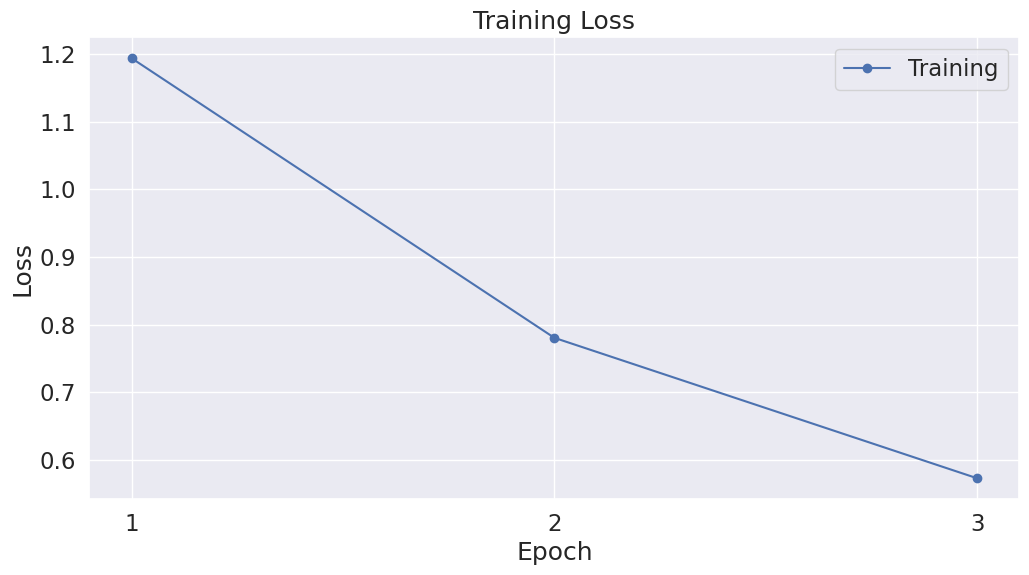

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_stats = pd.read_parquet(f"{output_dir}/training_stats.parquet")

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")

plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

13. Load and test the model.

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = torch.device("cuda"  if torch.cuda.is_available() else  "cpu")

tokenizer = AutoTokenizer.from_pretrained(f"nicholasKluge/{project}")
aira = AutoModelForCausalLM.from_pretrained(f"nicholasKluge/{project}")

aira.eval()
aira.to(device)

question =  input("Enter your question: ")

inputs = tokenizer(tokenizer.bos_token + question + tokenizer.sep_token, return_tensors="pt").to(device)

responses = aira.generate(**inputs,
    bos_token_id=tokenizer.bos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    do_sample=True,
    top_k=20,
    max_length=530,
    top_p=0.20,
    temperature=0.2,
    num_return_sequences=2)

print(f"Question: 👤 {question}\n")

for i, response in  enumerate(responses):
    print(f'Response {i+1}: 🤖 {tokenizer.decode(response, skip_special_tokens=True).replace(question, "")}')

Question: 👤 Quem foi o primeiro homem a pisar na lua?

Response 1: 🤖 O primeiro homem a pisar na Lua foi o astronauta Neil Armstrong. Ele fez isso em 20 de julho de 1969, durante a missão Apollo 11.
Response 2: 🤖 O primeiro homem a pisar na Lua foi o astronauta Neil Armstrong. Ele fez isso em 20 de julho de 1969, durante a missão Apollo 11.


Done! 🤗